In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa_plots

In [3]:
df = pd.read_excel('AirlinesData.xlsx',index_col='Month',parse_dates=True)
df

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


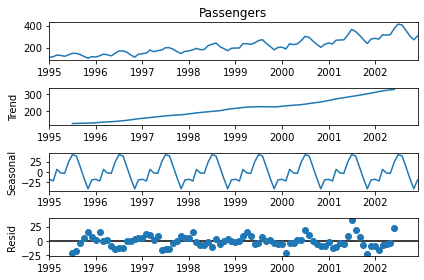

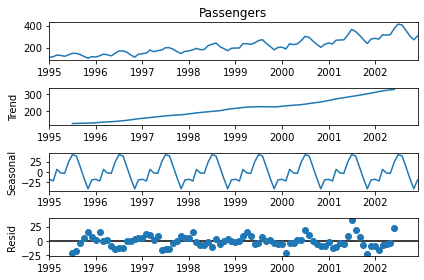

In [4]:
decompose_ts = seasonal_decompose(df['Passengers'],period=12)
decompose_ts.plot()

## Augmented Dickey Fuller Test

In [5]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [6]:
adf_test(df['Passengers'])

Fail to reject the null hypothesis
Data is non-stationary


## first order differencing

In [7]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df['Passengers'],k_diff=1)
adf_test(df['d1'])

Fail to reject the null hypothesis
Data is non-stationary


## Second order differencing

In [8]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df['Passengers'],k_diff=2)
adf_test(df['d1'])

Reject the null hypothesis
Data is stationary


## Model Building

In [9]:
!pip install --user pmdarima

In [10]:
from pmdarima import auto_arima

In [11]:
stepwise_fit = auto_arima(df['Passengers'], start_p=0, start_d=1, start_q=0,
                          max_p=10, max_d=3, max_q=10, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True, 
                          stepwise=True)          

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=871.345, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=867.283, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=863.757, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=870.076, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=862.193, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=861.773, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=860.702, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=862.251, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=855.919, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=860.821, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=856.719, Time=0.10 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -421.170
Date:                Wed, 06 Oct 2021   AIC                            854.341
Time:                        14:04:16   BIC                            869.664
Sample:                             0   HQIC                           860.533
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1526      0.142      1.071      0.284      -0.127       0.432
ar.L2          0.4062      0.144      2.815      0.005       0.123       0.689
ar.L3         -0.3167      0.121     -2.619      0.009      -0.554      -0.080
ma.L1          0.1470      0.121      1.215      0.224      -0.090       0.384
ma.L2         -0.7809      0.116     -6.734      0.000      -1.008      -0.554
sigma2       409.9286     75.390      5.437      0.000     262.167     557.690
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 3.94
Prob(Q):                              0.41   Prob(JB):                         0.14
Heteroskedasticity (H):               3.63   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data into train/test sets

In [12]:
len(df)

96

In [13]:
train = df.iloc[:80]
test = df.iloc[80:]

### Fit an ARIMA(2,2,1) Model

In [14]:
from statsmodels.tsa.arima_model import ARIMA

In [15]:
model = ARIMA(train['Passengers'],order=(3,1,2))
results = model.fit()
results.summary()

C:\Users\Mayu\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Mayu\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Passengers   No. Observations:                   79
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -339.127
Method:                       css-mle   S.D. of innovations             17.107
Date:                Wed, 06 Oct 2021   AIC                            692.253
Time:                        14:04:17   BIC                            708.839
Sample:                    02-01-1995   HQIC                           698.898
                         - 08-01-2001                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.8064      2.043      1.373      0.170      -1.198       6.811
ar.L1.D.Passengers     0.9909      0.149      6.653      0.000       0.699       1.283
ar.L2.D.Passengers    -1.0071      0.150     -6.699      0.000      -1.302      -0.712
ar.L3.D.Passengers     0.0114      0.143      0.080      0.937      -0.269       0.292
ma.L1.D.Passengers    -0.9343      0.098     -9.488      0.000      -1.127      -0.741
ma.L2.D.Passengers     1.0000      0.055     18.158      0.000       0.892       1.108
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4917           -0.8731j            1.0020           -0.1684
AR.2            0.4917           +0.8731j            1.0020            0.1684
AR.3           87.3635           -0.0000j           87.3635           -0.0000
MA.1            0.4671           -0.8842j            1.0000           -0.1726
MA.2            0.4671           +0.8842j            1.0000            0.1726
-----------------------------------------------------------------------------
"""

## Checking Predictions

In [16]:
start=len(train)
end=len(df)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
predictions = predictions.rename('ARIMA(3,1,2) Predictions')

In [17]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Passengers'][i]}")

predicted=339.7535342, expected=312
predicted=327.7552063, expected=274
predicted=325.7904916, expected=237
predicted=338.6650708, expected=278
predicted=356.0844256, expected=284
predicted=363.1762698, expected=277
predicted=355.6265185, expected=317
predicted=344.021527 , expected=313
predicted=343.026665 , expected=318
predicted=356.4626664, expected=374
predicted=373.4660365, expected=413
predicted=379.5913051, expected=405
predicted=371.5091318, expected=355
predicted=360.3453026, expected=306
predicted=360.3127945, expected=271
predicted=374.2520079, expected=306


In [18]:
import matplotlib.pyplot as plt

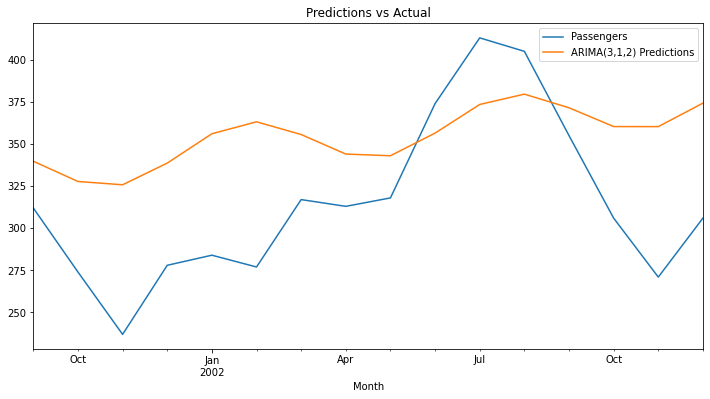

In [19]:
title = 'Predictions vs Actual'
ylabel='Passengers'
xlabel='' 

test['Passengers'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
plt.show()

### Evaluate the Model

In [20]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Passengers'], predictions)
error.round(2)

3081.52

In [21]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Passengers'], predictions)
error.round(2)

55.51

In [22]:
test['Passengers'].mean()

315.0

### Retrain the model on the full data, and forecast the future

In [23]:
model = ARIMA(df['Passengers'],order=(3,1,2))
results = model.fit()
fcast = results.predict(len(df),len(df)+16,typ='levels').rename('ARIMA(3,1,2) Forecast')

C:\Users\Mayu\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Mayu\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


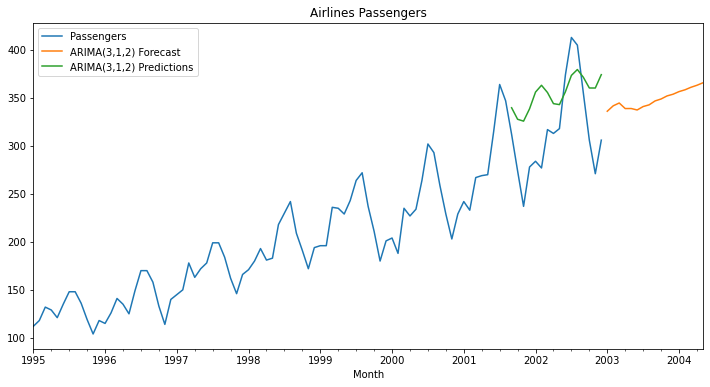

In [24]:
# Plot predictions against known values
title = 'Airlines Passengers'
ylabel='Passengers'
xlabel='Period' 

df['Passengers'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
predictions.plot(legend=True)
plt.show()